# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

<b>Порядок выполнения проекта:</b>
1. Загрузка и подготовка данные.
1. Исследование баланс классов, обучение модели без учёта дисбаланса.
1. Улучшение качества модели, с учетом дисбаланса классов. Обучение разных моделей и поиск лучшей.
1. Проведение финального тестирования.

<b>Описание данных:</b>
<br>Данные находятся в файле /datasets/Churn.csv (англ. «отток клиентов»).


Признаки:
* RowNumber — индекс строки в данных
* CustomerId — уникальный идентификатор клиента
* Surname — фамилия
* CreditScore — кредитный рейтинг
* Geography — страна проживания
* Gender — пол
* Age — возраст
* Tenure — сколько лет человек является клиентом банка
* Balance — баланс на счёте
* NumOfProducts — количество продуктов банка, используемых клиентом
* HasCrCard — наличие кредитной карты
* IsActiveMember — активность клиента
* EstimatedSalary — предполагаемая зарплата

Целевой признак:
* Exited — факт ухода клиента

In [1]:
#импорт библиотек

#основные
import pandas as pd
import numpy as np
from tqdm import tqdm

#математика
import math
from math import factorial
from math import sqrt
import random

#статистика
from scipy import stats
from scipy.stats import binom

#графики
import matplotlib.pyplot as plt
from sklearn import tree

#машинное обучение - общее
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler 

#машинное обучение - классификация
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier

In [2]:
def explain_dataset(dataset, hist_on):
    dataset.info()
    print()
    print('количество полных дубликатов в таблице =', dataset.duplicated().sum())
    pd.set_option('display.max_columns', None)
    display(dataset.describe())
    display(dataset.head(10))
    if hist_on: dataset.hist(figsize=(15, 20), bins=30);

In [3]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [4]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

## Подготовка данных

### Загрузка данных и проверка датасета

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB

количество полных дубликатов в таблице = 0


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


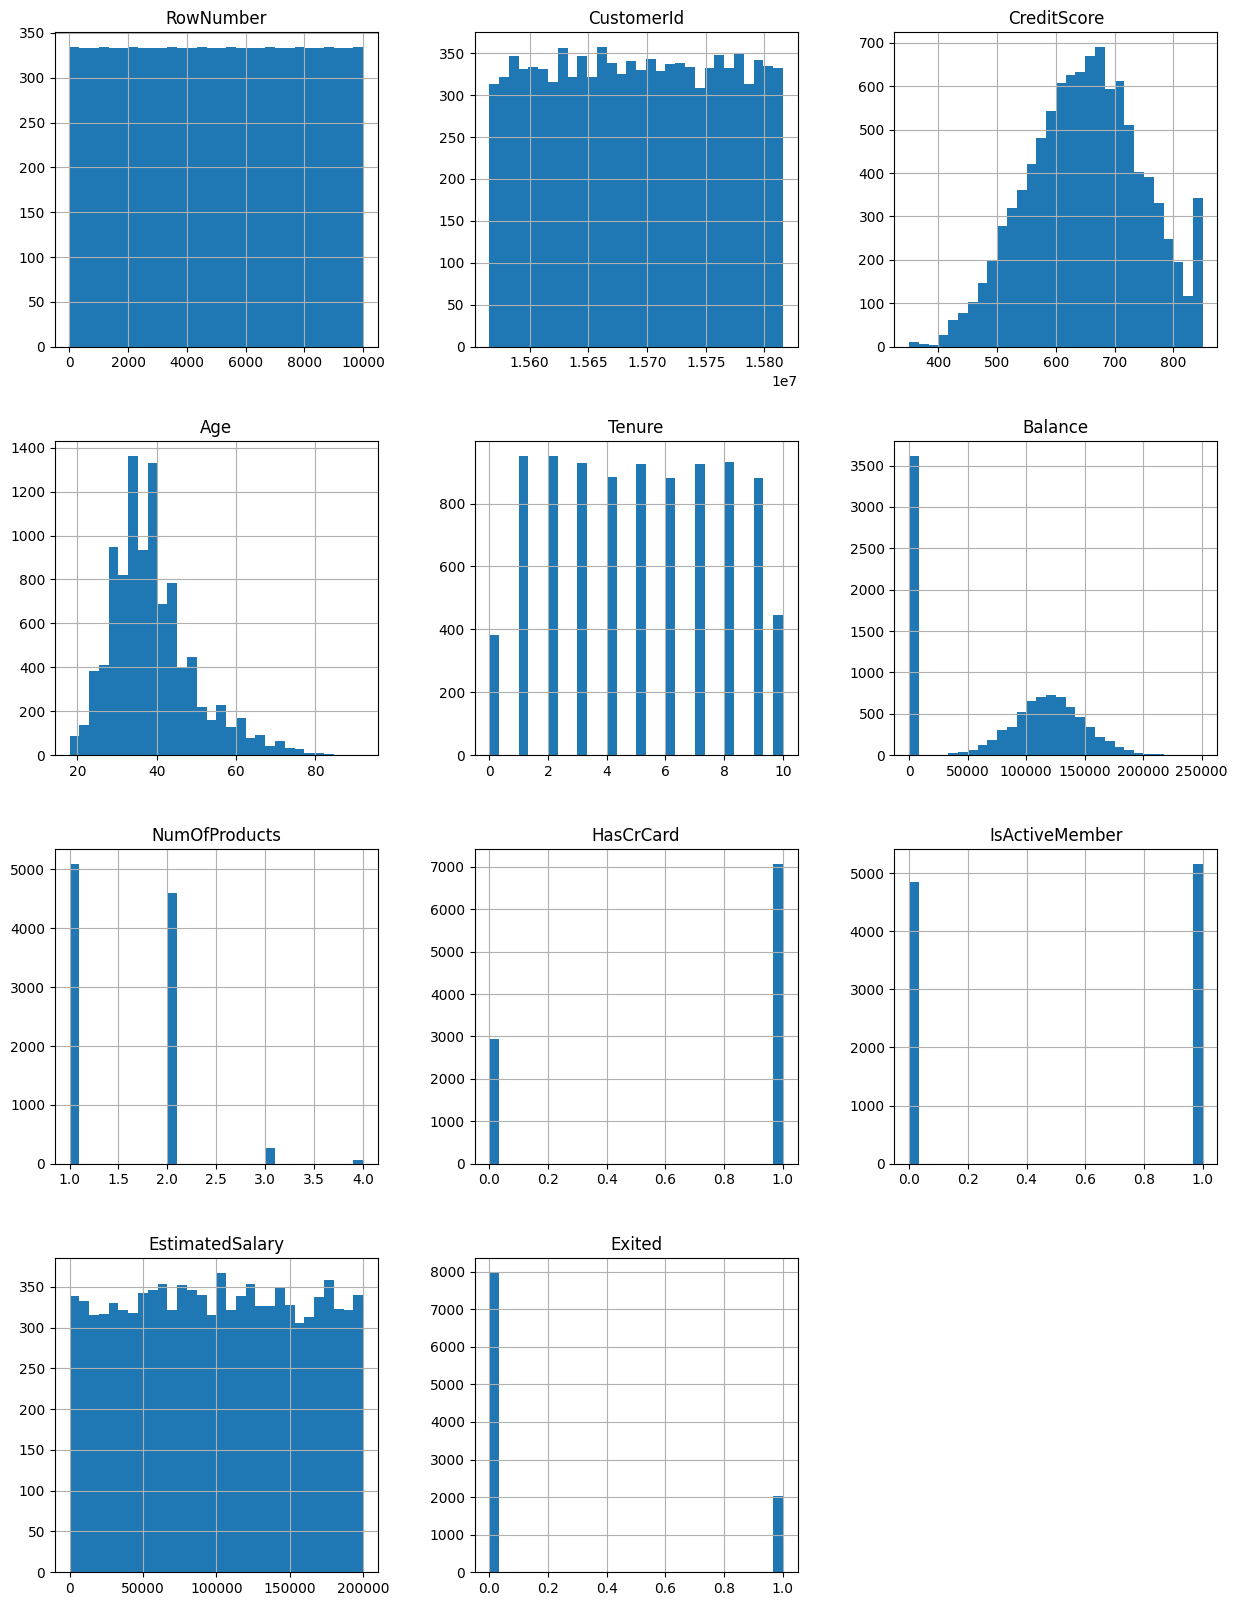

In [5]:
#импортируем данные из файла /datasets/Churn.csv в датасет data
data = pd.read_csv('Churn.csv')

#проверяем что информация из таблицы корректно загрузилась в датасет
explain_dataset(data, True)

Изучение датасета показало, что в признаке Tenure есть пропуски в данных. В рамках исследования мы будет трактовать клинтов с таким значением этого признака, как людей, являющихся клиентами банка менее года. Для корректного обучения моделей лучше заменить null на 0.

In [6]:
def fill_random(x):
    if pd.isnull(x):
        return random.randint(1,10)
    else:
        return x

In [7]:
#заддадим зерно рандома, чтобы при перезапуске тетрадки - числа были одни и те же
random.seed(12345)

#заполним пропуски в признаке Tenure случайными числами
data['Tenure'] = data['Tenure'].apply(fill_random)

#проверим, заполнены ли пропуски в признаке
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Выводы по п.1.1:
- данные импортированы успешно, набор признаков в датасете совпадает с документацией.
- датасет содержит 10000 записей, отсутствуют полные дубликаты.
- типы данных признаков соответствуют данным, которые в них содержаться.
- значения null в признаке Tenure заменили на случайное число от 1 до 10, чтобы не они не влияли на распределение
- данные во всех остальных признаках - полные, пригодны для анализа и не требуют дальнейшей предобработки.
- целевой признак Exited - категориальный (либо клиент ушел из банка, либо нет), значи перед нами в данном исследовании стоит задача классификации.
- в датасете присутствуют три категориальных признака (Surname, Geography и Gender), которые потенциально нужно будет перекодировать, чтобы их можно было использовать для обучения моделей.
- поскольку в рамках данного анализа мы будем использовать только модели линейной регрессии, решающего дерева и случайного леса, у нас нет необходимости производить масштабирование (среднее арифметическое = 0, дисперсия = 1), поскольку данные методы машиного обучения не чувствительны к различию в масштабах признаков.

### Кодирование категориальных признаков

Поскольку в датасете содержаться категориальные признаки - нужно перекодировать их таким образом, чтобы все признаки были числовыми. Для этого воспользуемся методом One-Hot-Encoding, т.к. далее буду рассматриваться не только модели на основе решающих деревьев, но и модель логистической регрессии.

В датасете присутствуют следующие категориальные признаки:
* Surname — фамилия
* Geography — страна проживания
* Gender — пол
Поскольку фамилия клиента банка никак не влияет на целевой признак - уйдет ли клиент из банка или нет - для дальнейшего обучения моделей мы сформируем новый датасет, из которого исключим информацию о фамилии. В дальнейшем ее можно будет восстановить из исходного датасета по уникальному коду клиента.

In [8]:
#создадим новый датасет data_clear, включающие все призанки исходного, кроме Surname
data_clear = data.drop(['Surname'], axis=1)

#проверим получившийся датасет
data_clear.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  float64
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 1015.8+ KB


In [9]:
#удалим из нового датасета RowNumber и CustomerId
data_clear = data_clear.drop(['RowNumber'], axis=1)
data_clear = data_clear.drop(['CustomerId'], axis=1)

#проверим получившийся датасет
data_clear.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  float64
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


In [10]:
#перекодируем признаки методом ohe, отбросим первый столбец, чтобы избежать дамми-ловушки
data_ohe = pd.get_dummies(data_clear, drop_first=True)

#проверим получившийся в датасете столбцы с результатами перекодировки признаков
data_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Tenure             10000 non-null  float64
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  int64  
 5   HasCrCard          10000 non-null  int64  
 6   IsActiveMember     10000 non-null  int64  
 7   EstimatedSalary    10000 non-null  float64
 8   Exited             10000 non-null  int64  
 9   Geography_Germany  10000 non-null  bool   
 10  Geography_Spain    10000 non-null  bool   
 11  Gender_Male        10000 non-null  bool   
dtypes: bool(3), float64(3), int64(6)
memory usage: 732.6 KB


Выводы по п.1.2:
- признак Surname не влияет на целевой признак и его можно отбросить из выборки
- два оставшихся категориальных признака перекодированы в числовые
- итоговая таблица содержит 14 признаков, подходит для дальнейшего использования данных из нее при обучении моделей

<b>Итого по п.1:</b>
- данные импортированы успешно, набор признаков в датасете совпадает с документацией.
- значения null в признаке Tenure заменили на ноль, в рамках исследования мы будет трактовать клинтов с таким значением признака, как людей, являющихся клиентами банка менее года.
- целевой признак Exited - категориальный (либо клиент ушел из банка, либо нет), значи перед нами в данном исследовании стоит задача классификации.
- поскольку в рамках данного анализа мы будем использовать только модели линейной регрессии, решающего дерева и случайного леса, у нас нет необходимости производить масштабирование (среднее арифметическое = 0, дисперсия = 1), так как данные методы машиного обучения не чувствительны к различию в масштабах признаков.
- категориальный признак Surname не влияет на целевой признак и его можно отбросить из выборки
- два оставшихся категориальных признака (Geography и Gender)успешно перекодированы в числовые

## Исследование задачи

### Исследование баланса классов
Для того, чтобы подготовить итоговую модель с наибольшими значением F1-меры, нужно учитывать, насколько сбалансированным является целевой признак в полученной нами выборке. 
<br>В рамках данного исследования нам нужно предсказать значения целевого признака Exited, чтобы определить, уйдет клиент от банка или нет. Выделим его в отдельный массив и рассмотрим соотношение положительных и отрицательных значений

In [11]:
#выделим целевой признак в отдельный массив target, а все остальные признаки - в датасет features
features = data_ohe.drop(['Exited'], axis=1)
target = data_ohe['Exited']

#изучим датасет features, чтобы проверить разделение
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Tenure             10000 non-null  float64
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  int64  
 5   HasCrCard          10000 non-null  int64  
 6   IsActiveMember     10000 non-null  int64  
 7   EstimatedSalary    10000 non-null  float64
 8   Geography_Germany  10000 non-null  bool   
 9   Geography_Spain    10000 non-null  bool   
 10  Gender_Male        10000 non-null  bool   
dtypes: bool(3), float64(3), int64(5)
memory usage: 654.4 KB


In [12]:
#изучим количество уникальных значений в массиве target
print(target.value_counts())

#рассмотрим соотношение положительных и отрицательных ответов
print('')
print(f'Отношение 0 к 1 : {target[target == 0].count() / target[target == 1].count():.3f}')

Exited
0    7963
1    2037
Name: count, dtype: int64

Отношение 0 к 1 : 3.909


Выводы по п.2.1.
- Отрицательных ответов почти в 4 раза больше, чем положительных - целевой признак нельзя назвать сбалансированным
- Потребуется скорректировать дисбаланс классов, чтобы достигнуть наилучшего результата при обучении модели.

### Изучение модели без учёта дисбаланса классов
Перед тем, как выбрать способ компенсации дисбаланса классов - подготовим и изучим модели без учета дисбаланса, чтобы далее можно было использовать полученные результаты как отправную точку для балансировки классов и улучшения моделей.

Для обучения моделей, подготовим выборки с обучающими, валидационными и тестовыми данными:
- _test - тестовые данные для итоговой проверки
- _valid - валидационные данные для настройки
- _train - обучающие данные дня подготовки модели

In [13]:
#рассчитаем какое количество записей составит 1\4 о всех записей в датасете
target.count()/4

2500.0

In [14]:
#выделяем 1/4 (2500 записей) от исходного датасета в пару тестовых датасетов
features2, features_test, target2, target_test = train_test_split(features, target, test_size=2500, random_state=12345, stratify=target)

#выделяем 1/4 (2500 записей) от исходного датасета в пару датасетов с валидационными данными
#остальное - в датасеты с обучающими данными
features_train, features_valid, target_train, target_valid = train_test_split(features2, target2, test_size=2500, random_state=12345, stratify=target2)

#выведем информацию о количестве записей в получившихся датасетах, чтобы проверить корректность разделения
print(f'Датасет features_train: {features_train["CreditScore"].count()}')
print(f'Датасет target_train: {target_train.count()}')
print()
print(f'Датасет features_valid: {features_valid["CreditScore"].count()}')
print(f'Датасет target_valid: {target_valid.count()}')
print()
print(f'Датасет features_test: {features_test["CreditScore"].count()}')
print(f'Датасет target_test: {target_test.count()}')

Датасет features_train: 5000
Датасет target_train: 5000

Датасет features_valid: 2500
Датасет target_valid: 2500

Датасет features_test: 2500
Датасет target_test: 2500


Поскольку числовые признаки сейчас в разном масштабе - приведем их к единому для дальшейшего обучения моделей

In [15]:
#создадим и обучим инструмент стандартизации
scaler = StandardScaler()
scaler.fit(features_train) 

features_train_init = features_train
features_valid_init = features_valid
features_test_init = features_test

In [16]:
#приведем выборки к единому масштабы
features_train = scaler.transform(features_train_init)
features_valid = scaler.transform(features_valid_init)
features_test = scaler.transform(features_test_init) 

#преобразуем получившиеся numpy.ndarray в структуры pandas.dataframe
features_train = pd.DataFrame(data=features_train, columns = features_train_init.columns.values.tolist(), index=features_train_init.index.values.tolist())
features_valid = pd.DataFrame(data=features_valid, columns = features_valid_init.columns.values.tolist(), index=features_valid_init.index.values.tolist())
features_test = pd.DataFrame(data=features_test, columns = features_test_init.columns.values.tolist(), index=features_test_init.index.values.tolist())


Для построения наилучшей модели мы исследуем три типа моделей и подберем для каждой свои оптимальные гиперпараметры, ориентируясь на результат f1_score.
<br>
<br> Рассмотрим следующие модели:
- Модель решающего дерева DecisionTreeClassifier, для которой будет оптимизировать максимальную глубину дерева (max_depth)
- Модель случайного леса RandomForestClassifier, для которого будем оптимизировать количество деревьев (n_estimators) и максимальную глубину дерева (max_depth)
- Модель логистической регрессии LogisticRegression, для которой будем оптимизировать количество итераций (max_iter)

#### Модель решающего дерева

Наилучший результат f1_score 0.539834 показала модель решающего дерева с max_depth = 7


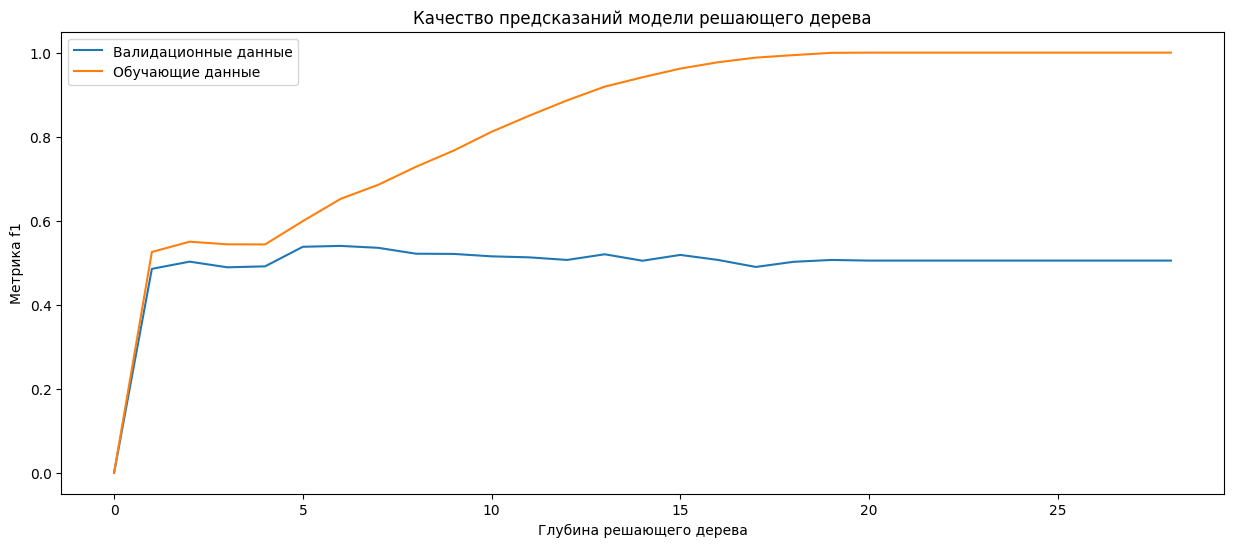

In [17]:
# подберем наилучшее значение max_depth для модели решающего дерева
best_DT_model = None
best_DT_result = 0
best_depth = 0
f1_valid = []
f1_train = []

for depth in range(1, 30):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)

    predictions = model.predict(features_valid)
    result = f1_score(predictions, target_valid)
    f1_valid.append(result)

    predictions_train = model.predict(features_train)
    f1_train.append(f1_score(predictions_train, target_train))

    if result > best_DT_result:
        best_DT_model = model
        best_DT_result = result
        best_depth = depth

print(f'Наилучший результат f1_score {best_DT_result:0.06} показала модель решающего дерева с max_depth = {best_depth}')

plt.figure(figsize=(15, 6))
plt.plot(f1_valid, label='Валидационные данные');
plt.plot(f1_train, label='Обучающие данные');
plt.legend()
plt.title('Качество предсказаний модели решающего дерева')
plt.ylabel('Метрика f1')
plt.xlabel('Глубина решающего дерева')
plt.show()

Значение метрики AUC-ROC: 0.825505


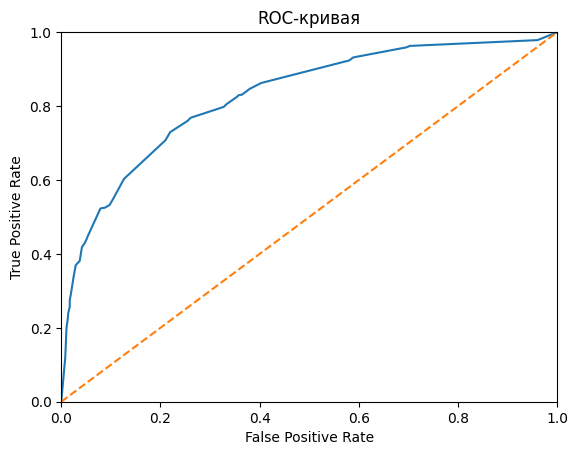

In [18]:
#построим ROC-кривую и проверим метрику AUC-ROC для модели

probabilities_valid = best_DT_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(f'Значение метрики AUC-ROC: {auc_roc:.6f}')

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

#### Модель случайного леса

In [19]:
#подберем наилучшее значение n_estimators и max_depth для модели случайного леса
best_RF_model = None
best_RF_result = 0
best_est = 0
best_depth = 0

for est in tqdm(range(1, 30)):
    for depth in range(2, 20):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
    
        predictions = model.predict(features_valid)
        result = f1_score(predictions, target_valid)
    
        if result > best_RF_result:
            best_RF_model = model
            best_RF_result = result
            best_est = est
            best_depth = depth
    
print(f'Наилучший результат f1_score {best_RF_result:0.06} показала модель случайного леса с n_estimators = {best_est} и max_depth = {best_depth}')

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.34s/it]

Наилучший результат f1_score 0.560197 показала модель случайного леса с n_estimators = 29 и max_depth = 16


Значение метрики AUC-ROC: 0.831938


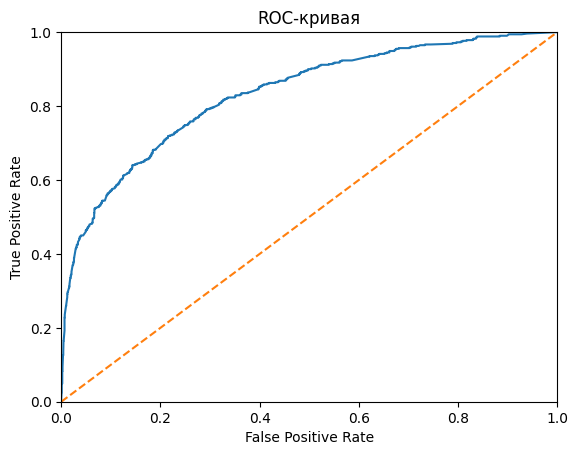

In [20]:
#построим ROC-кривую и проверим метрику AUC-ROC для модели

probabilities_valid = best_RF_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(f'Значение метрики AUC-ROC: {auc_roc:.6f}')

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

#### Модель логистической регрессии

In [21]:
# подберем наилучшее значение max_iter для модели логистической регрессии
best_LR_model = None
best_LR_result = 0
best_max_iter = 0

for iter_num in tqdm(range(100, 500, 10)):
    model = LogisticRegression(random_state=12345, solver='liblinear', max_iter=iter_num)
    model.fit(features_train, target_train)

    predictions = model.predict(features_valid)
    result = f1_score(predictions, target_valid)

    if result > best_LR_result:
        best_LR_model = model
        best_LR_result = result
        best_max_iter = iter_num

print(f'Наилучший результат f1_score {best_LR_result:.2f} показала модель логистической регрессии с max_iter = {best_max_iter}')

100%|█████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 105.26it/s]

Наилучший результат f1_score 0.33 показала модель логистической регрессии с max_iter = 100


Значение метрики AUC-ROC: 0.756100


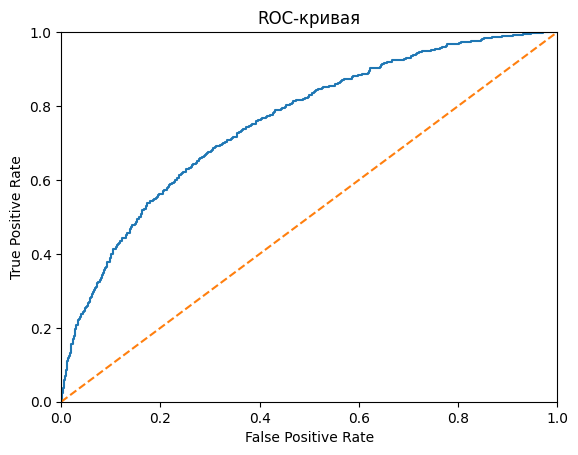

In [22]:
#построим ROC-кривую и проверим метрику AUC-ROC для модели

probabilities_valid = best_LR_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(f'Значение метрики AUC-ROC: {auc_roc:.6f}')

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Выводы по п.2.2
- Исследованы и протестированы 3 модели для задачи классификации:
    - Модель решающего дерева
    - Модель случайного леса
    - Модель логистической регрессии
- Наилучший результат f1_score 0.539834 показала модель решающего дерева с max_depth = 7, AUC-ROC:0.825505
- Наилучший результат f1_score 0.560197 показала модель случайного леса с n_estimators = 29 и max_depth = 16, AUC-ROC:0.831938
- Наилучший результат f1_score 0.33 показала модель логистической регрессии с max_iter = 100, AUC-ROC: 0.756100

<b>Итого по п.2:</b>
- Отрицательных ответов почти в 4 раза больше, чем положительных - целевой признак нельзя назвать сбалансированным
- Без учета дисбаланса классов, исследованы и протестированы 3 модели для задачи классификации:
    - Модель решающего дерева
    - Модель случайного леса
    - Модель логистической регрессии
- Наилучший результат f1_score 0.539834 показала модель решающего дерева с max_depth = 7, AUC-ROC:0.825505
- Наилучший результат f1_score 0.560197 показала модель случайного леса с n_estimators = 29 и max_depth = 16, AUC-ROC:0.831938
- Наилучший результат f1_score 0.33 показала модель логистической регрессии с max_iter = 100, AUC-ROC: 0.756100
- Таким образом для данных с несбалансированными классами наиболее точной оказалась модель случайного леса, показавшая результат f1_score 0.560197 с количеством деревьев равным 29 и максимальной глубиной в 16, AUC-ROC:0.831938

## Борьба с дисбалансом
Для того, чтобы исправить ситуацию с дисбалансом классов, опробуем три различных подхода к решению этой проблемы:
- Взвешивание классов
- Увеличение выборки
- Уменьшение выборки

### Взвешивание классов
Используем гиперпараметр class_weight='balanced', чтобы сбалансировать количество положительных и отрицательных исходов, при обучении модели

Наилучший результат f1_score 0.576547 показала модель решающего дерева с max_depth = 7, AUC-ROC:0.8186


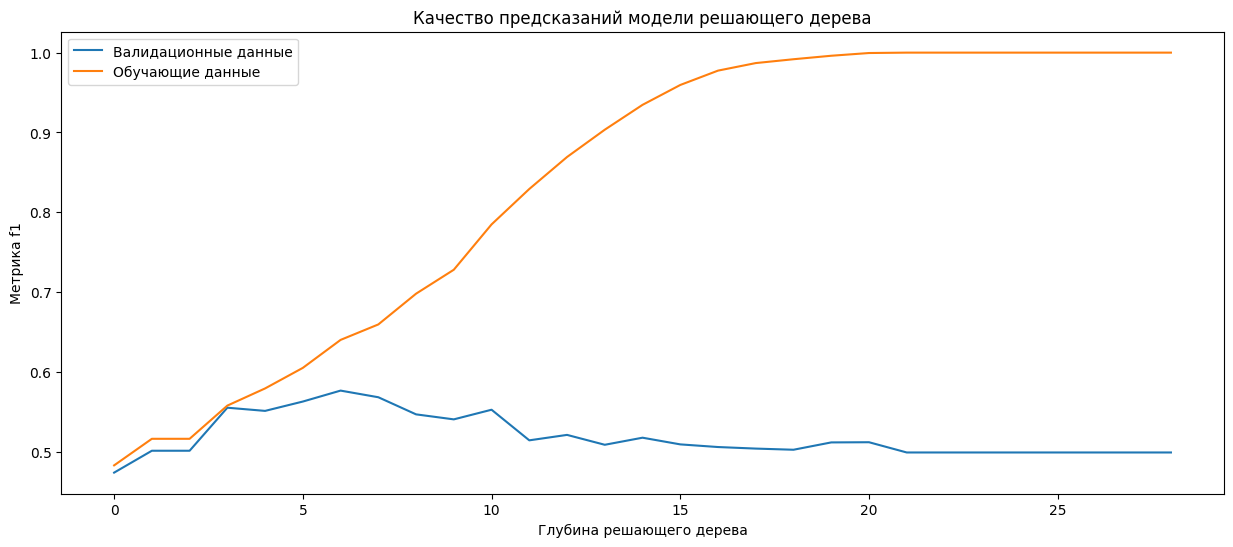

In [23]:
# подберем наилучшее значение max_depth для модели решающего дерева c взвешенными классами
best_DT_model = None
best_DT_result = 0
best_depth = 0
f1_valid = []
f1_train = []

for depth in range(1, 30):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model.fit(features_train, target_train)

    predictions = model.predict(features_valid)
    result = f1_score(predictions, target_valid)
    f1_valid.append(result)

    predictions_train = model.predict(features_train)
    f1_train.append(f1_score(predictions_train, target_train))

    if result > best_DT_result:
        best_DT_model = model
        best_DT_result = result
        best_depth = depth


#рассчитаем метрику AUC-ROC для модели
probabilities_valid = best_DT_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
        
print(f'Наилучший результат f1_score {best_DT_result:0.06} показала модель решающего дерева с max_depth = {best_depth}, AUC-ROC:{auc_roc:.4f}')

plt.figure(figsize=(15, 6))
plt.plot(f1_valid, label='Валидационные данные');
plt.plot(f1_train, label='Обучающие данные');
plt.legend()
plt.title('Качество предсказаний модели решающего дерева')
plt.ylabel('Метрика f1')
plt.xlabel('Глубина решающего дерева')
plt.show()


In [24]:
#подберем наилучшее значение n_estimators и max_depth для модели случайного леса c взвешенными классами
best_RF_model = None
best_RF_result = 0
best_est = 0
best_depth = 0

for est in tqdm(range(1, 30)):
    for depth in range(2, 20):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, class_weight='balanced')
        model.fit(features_train, target_train)
    
        predictions = model.predict(features_valid)
        result = f1_score(predictions, target_valid)
    
        if result > best_RF_result:
            best_RF_model = model
            best_RF_result = result
            best_est = est
            best_depth = depth

#рассчитаем метрику AUC-ROC для модели
probabilities_valid = best_RF_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)           

print(f'Наилучший результат f1_score {best_RF_result:0.06} показала модель случайного леса с n_estimators = {best_est} и max_depth = {best_depth}, AUC-ROC:{auc_roc:.4f}')

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [01:08<00:00,  2.35s/it]

Наилучший результат f1_score 0.616043 показала модель случайного леса с n_estimators = 29 и max_depth = 11, AUC-ROC:0.8477


In [25]:
# подберем наилучшее значение max_iter для модели логистической регрессии c взвешенными классами
best_LR_model = None
best_LR_result = 0
best_max_iter = 0

for iter_num in tqdm(range(100, 500, 10)):
    model = LogisticRegression(random_state=12345, solver='liblinear', max_iter=iter_num, class_weight='balanced')
    model.fit(features_train, target_train)

    predictions = model.predict(features_valid)
    result = f1_score(predictions, target_valid)

    if result > best_LR_result:
        best_LR_model = model
        best_LR_result = result
        best_max_iter = iter_num

#рассчитаем метрику AUC-ROC для модели
probabilities_valid = best_LR_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)       

print(f'Наилучший результат f1_score {best_LR_result:.2f} показала модель логистической регрессии с max_iter = {best_max_iter}, AUC-ROC:{auc_roc:.4f}')

100%|█████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 109.18it/s]

Наилучший результат f1_score 0.48 показала модель логистической регрессии с max_iter = 100, AUC-ROC:0.7598


Выводы по п.3.1:
- Наилучший результат f1_score 0.576547 показала модель решающего дерева с max_depth = 7, AUC-ROC:0.8186
- Наилучший результат f1_score 0.61301 показала модель случайного леса с n_estimators = 29 и max_depth = 12, AUC-ROC:0.8445
- Наилучший результат f1_score 0.48 показала модель логистической регрессии с max_iter = 100, AUC-ROC:0.7598

### Увеличение выборки
С помощью повторения положительных ответов, увеличим их количество таким образом, чтобы количество положительных и отрицательных ответов примерно сравнялось

In [26]:
#подготовим обучающие выборки для моделей с использованием метода увеличение количества положительных ответов
#features_upsampled, target_upsampled = upsample(features_train, target_train, 4)
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

#посмотрим на получившийся датасет
features_upsampled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8057 entries, 1569 to 7894
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        8057 non-null   float64
 1   Age                8057 non-null   float64
 2   Tenure             8057 non-null   float64
 3   Balance            8057 non-null   float64
 4   NumOfProducts      8057 non-null   float64
 5   HasCrCard          8057 non-null   float64
 6   IsActiveMember     8057 non-null   float64
 7   EstimatedSalary    8057 non-null   float64
 8   Geography_Germany  8057 non-null   float64
 9   Geography_Spain    8057 non-null   float64
 10  Gender_Male        8057 non-null   float64
dtypes: float64(11)
memory usage: 755.3 KB


Наилучший результат f1_score 0.572741 показала модель решающего дерева с max_depth = 7, AUC-ROC:0.8477


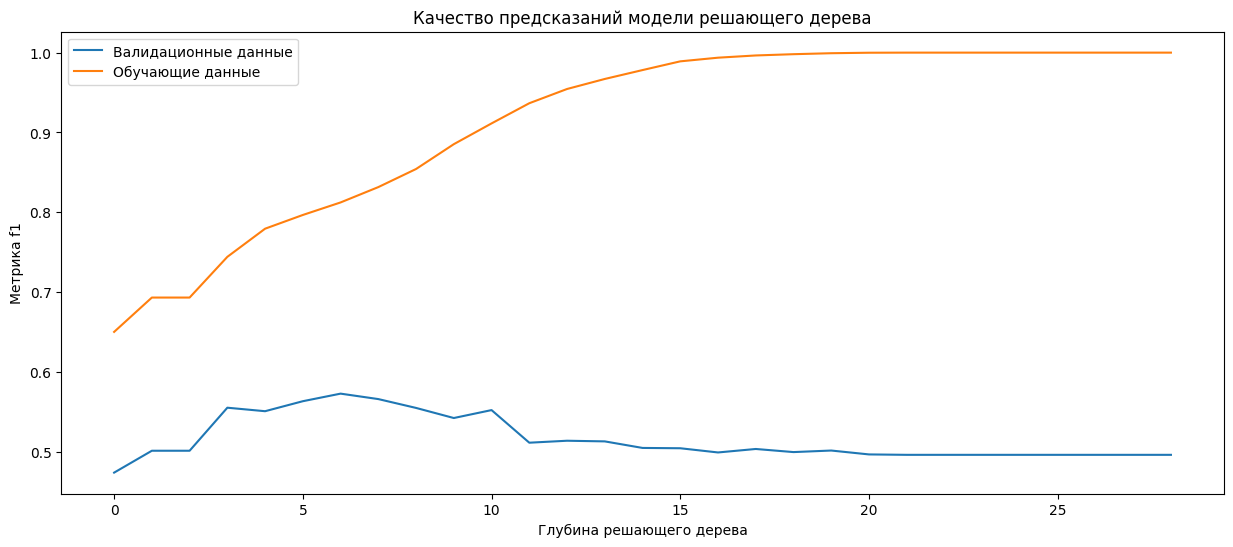

In [27]:
# подберем наилучшее значение max_depth для модели решающего дерева на увеличенных данных
best_DT_model = None
best_DT_result = 0
best_depth = 0
f1_valid = []
f1_train = []

for depth in range(1, 30):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_upsampled, target_upsampled)

    predictions = model.predict(features_valid)
    result = f1_score(predictions, target_valid)
    f1_valid.append(result)

    predictions_train = model.predict(features_upsampled)
    f1_train.append(f1_score(predictions_train, target_upsampled))

    if result > best_DT_result:
        best_DT_model = model
        best_DT_result = result
        best_depth = depth

#рассчитаем метрику AUC-ROC для модели
probabilities_valid = best_RF_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
        
print(f'Наилучший результат f1_score {best_DT_result:0.06} показала модель решающего дерева с max_depth = {best_depth}, AUC-ROC:{auc_roc:.4f}')


plt.figure(figsize=(15, 6))
plt.plot(f1_valid, label='Валидационные данные');
plt.plot(f1_train, label='Обучающие данные');
plt.legend()
plt.title('Качество предсказаний модели решающего дерева')
plt.ylabel('Метрика f1')
plt.xlabel('Глубина решающего дерева')
plt.show()

In [28]:
#подберем наилучшее значение n_estimators и max_depth для модели случайного леса на увеличенных данных
best_RF_model = None
best_RF_result = 0
best_est = 0
best_depth = 0

for est in tqdm(range(1, 30)):
    for depth in range(2, 20):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_upsampled, target_upsampled)
    
        predictions = model.predict(features_valid)
        result = f1_score(predictions, target_valid)
    
        if result > best_RF_result:
            best_RF_model = model
            best_RF_result = result
            best_est = est
            best_depth = depth
    
#рассчитаем метрику AUC-ROC для модели
probabilities_test = best_RF_model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)            

print(f'Наилучший результат f1_score {best_RF_result:0.06} показала модель случайного леса с n_estimators = {best_est} и max_depth = {best_depth}, AUC-ROC:{auc_roc:.4f}')

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [01:23<00:00,  2.89s/it]

Наилучший результат f1_score 0.614925 показала модель случайного леса с n_estimators = 29 и max_depth = 12, AUC-ROC:0.8523


In [29]:
# подберем наилучшее значение max_iter для модели логистической регрессии на увеличенных данных
best_LR_model = None
best_LR_result = 0
best_max_iter = 0

for iter_num in tqdm(range(100, 500, 10)):
    model = LogisticRegression(random_state=12345, solver='liblinear', max_iter=iter_num)
    model.fit(features_upsampled, target_upsampled)

    predictions = model.predict(features_valid)
    result = f1_score(predictions, target_valid)

    if result > best_LR_result:
        best_LR_model = model
        best_LR_result = result
        best_max_iter = iter_num

#рассчитаем метрику AUC-ROC для модели
probabilities_valid = best_LR_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)      

print(f'Наилучший результат f1_score {best_LR_result:.2f} показала модель логистической регрессии с max_iter = {best_max_iter}, AUC-ROC:{auc_roc:.4f}')

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 90.71it/s]

Наилучший результат f1_score 0.48 показала модель логистической регрессии с max_iter = 100, AUC-ROC:0.7599


Выводы по п.3.2:
- Наилучший результат f1_score 0.572741 показала модель решающего дерева с max_depth = 7, AUC-ROC:0.8487
- Наилучший результат f1_score 0.614925 показала модель случайного леса с n_estimators = 29 и max_depth = 12, AUC-ROC:0.8523
- Наилучший результат f1_score 0.48 показала модель логистической регрессии с max_iter = 100, AUC-ROC:0.7599

### Уменьшение выборки
Уравняем количество положительных и отрицательных ответов с помощью выборочного случайного удаление отрицательных ответов. 

In [30]:
#подготовим обучающие выборки для моделей с использованием метода уменьшения количества отрицательных ответов
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

#посмотрим на получившийся датасет
features_downsampled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2014 entries, 4520 to 2986
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        2014 non-null   float64
 1   Age                2014 non-null   float64
 2   Tenure             2014 non-null   float64
 3   Balance            2014 non-null   float64
 4   NumOfProducts      2014 non-null   float64
 5   HasCrCard          2014 non-null   float64
 6   IsActiveMember     2014 non-null   float64
 7   EstimatedSalary    2014 non-null   float64
 8   Geography_Germany  2014 non-null   float64
 9   Geography_Spain    2014 non-null   float64
 10  Gender_Male        2014 non-null   float64
dtypes: float64(11)
memory usage: 188.8 KB


Наилучший результат f1_score 0.56294 показала модель решающего дерева с max_depth = 7, AUC-ROC:0.8100


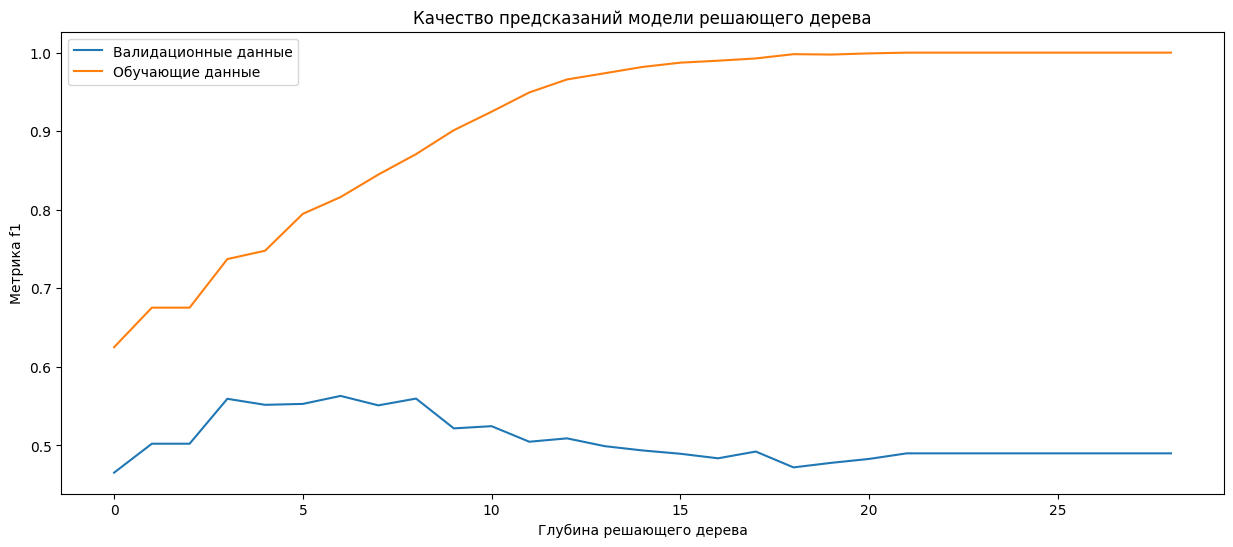

In [31]:
# подберем наилучшее значение max_depth для модели решающего дерева на уменьшеных данных
best_DT_model = None
best_DT_result = 0
best_depth = 0
f1_valid = []
f1_train = []

for depth in range(1, 30):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_downsampled, target_downsampled)

    predictions = model.predict(features_valid)
    result = f1_score(predictions, target_valid)
    f1_valid.append(result)

    predictions_train = model.predict(features_downsampled)
    f1_train.append(f1_score(predictions_train, target_downsampled))

    if result > best_DT_result:
        best_DT_model = model
        best_DT_result = result
        best_depth = depth

#рассчитаем метрику AUC-ROC для модели
probabilities_valid = best_DT_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
        
print(f'Наилучший результат f1_score {best_DT_result:0.06} показала модель решающего дерева с max_depth = {best_depth}, AUC-ROC:{auc_roc:.4f}')

plt.figure(figsize=(15, 6))
plt.plot(f1_valid, label='Валидационные данные');
plt.plot(f1_train, label='Обучающие данные');
plt.legend()
plt.title('Качество предсказаний модели решающего дерева')
plt.ylabel('Метрика f1')
plt.xlabel('Глубина решающего дерева')
plt.show()

In [32]:
#подберем наилучшее значение n_estimators и max_depth для модели случайного леса на уменьшеных данных
best_RF_model = None
best_RF_result = 0
best_est = 0
best_depth = 0

for est in tqdm(range(1, 30)):
    for depth in range(2, 20):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_downsampled, target_downsampled)
    
        predictions = model.predict(features_valid)
        result = f1_score(predictions, target_valid)
    
        if result > best_RF_result:
            best_RF_model = model
            best_RF_result = result
            best_est = est
            best_depth = depth
    
#рассчитаем метрику AUC-ROC для модели
probabilities_valid = best_RF_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)         

print(f'Наилучший результат f1_score {best_RF_result:0.06} показала модель случайного леса с n_estimators = {best_est} и max_depth = {best_depth}, AUC-ROC:{auc_roc:.4f}')

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:35<00:00,  1.22s/it]

Наилучший результат f1_score 0.604167 показала модель случайного леса с n_estimators = 20 и max_depth = 17, AUC-ROC:0.8398


In [33]:
# подберем наилучшее значение max_iter для модели логистической регрессии на уменьшеных данных
best_LR_model = None
best_LR_result = 0
best_max_iter = 0

for iter_num in tqdm(range(100, 500, 10)):
    model = LogisticRegression(random_state=12345, solver='liblinear', max_iter=iter_num)
    model.fit(features_downsampled, target_downsampled)

    predictions = model.predict(features_valid)
    result = f1_score(predictions, target_valid)

    if result > best_LR_result:
        best_LR_model = model
        best_LR_result = result
        best_max_iter = iter_num

#рассчитаем метрику AUC-ROC для модели
probabilities_valid = best_LR_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)     

print(f'Наилучший результат f1_score {best_LR_result:.2f} показала модель логистической регрессии с max_iter = {best_max_iter}, AUC-ROC:{auc_roc:.4f}')

100%|█████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 160.14it/s]

Наилучший результат f1_score 0.48 показала модель логистической регрессии с max_iter = 100, AUC-ROC:0.7609


Выводы по п.3.3:
- Наилучший результат f1_score 0.56294 показала модель решающего дерева с max_depth = 7, AUC-ROC:0.8100
- Наилучший результат f1_score 0.604167 показала модель случайного леса с n_estimators = 20 и max_depth = 17, AUC-ROC:0.8398
- Наилучший результат f1_score 0.48 показала модель логистической регрессии с max_iter = 100, AUC-ROC:0.7609

<b>Итого по п.3</b>
- При устранении дисбаланса методом взвешивания классов, получили следующие результаты:
    - Наилучший результат f1_score 0.576547 показала модель решающего дерева с max_depth = 7, AUC-ROC:0.8186
    - Наилучший результат f1_score 0.61301 показала модель случайного леса с n_estimators = 29 и max_depth = 12, AUC-ROC:0.8445
    - Наилучший результат f1_score 0.48 показала модель логистической регрессии с max_iter = 100, AUC-ROC:0.7598
    - Наилучшей моделью, при устранении дисбаланса методом взвешивания классов, оказалась модель случайного леса с n_estimators = 29 и max_depth = 12, AUC-ROC:0.8445, с результатом f1_score 0.61301
- При устранении дисбаланса методом увеличения выборки, получили следующие результаты:
    - Наилучший результат f1_score 0.572741 показала модель решающего дерева с max_depth = 7, AUC-ROC:0.8487
    - Наилучший результат f1_score 0.614925 показала модель случайного леса с n_estimators = 29 и max_depth = 12, AUC-ROC:0.8523
    - Наилучший результат f1_score 0.48 показала модель логистической регрессии с max_iter = 100, AUC-ROC:0.7599
    - Наилучшей моделью, при устранении дисбаланса методом увеличения выборки, оказалась модель случайного леса n_estimators = 29 и max_depth = 12, AUC-ROC:0.8523, с результатом f1_score 0.614925
- При устранении дисбаланса методом уменьшения выборки, получили следующие результаты:
    - Наилучший результат f1_score 0.56294 показала модель решающего дерева с max_depth = 7, AUC-ROC:0.8100
    - Наилучший результат f1_score 0.604167 показала модель случайного леса с n_estimators = 20 и max_depth = 17, AUC-ROC:0.8398
    - Наилучший результат f1_score 0.48 показала модель логистической регрессии с max_iter = 100, AUC-ROC:0.7609
    - Наилучшей моделью, при устранении дисбаланса методом уменьшения выборки, оказалась модель случайного леса с n_estimators = 20 и max_depth = 17, AUC-ROC:0.8398, с результатом f1_score 0.604167
- В рамках исследования лучше всего показали себя модели, обученные на данных, сбалансированных путем взвешивания классов и увеличения выборки, метод уменьшения выборки показал более низкие результаты, в финальном тестировании его нет смысла использовать
- Порог валидности моделей для данной задачи составляет f1_score > 0.59, его преодолели 2 модели, лучшей из которых, с f1_score 0.614925, оказалась модель случайного леса с n_estimators = 29 и max_depth = 12, обученная на данных, балансировка классов в которых производилась  методом увеличения выборки

## Тестирование модели
Еще раз обучим наилучшие модели из шага 3. и проверим их на тестовых данных.

### Подготовка моделей

In [34]:
#подготовим модель случайного леса с n_estimators = 29 и max_depth = 12, балансировка методом увеличения выборки
model2 = RandomForestClassifier(random_state=12345, n_estimators=29, max_depth=12)
model2.fit(features_upsampled, target_upsampled)
predictions2 = model2.predict(features_valid)
result = f1_score(predictions2, target_valid)

#проверим, что обучение прошло корректно и f1_score совпадает с результатами в п.3
print(f'модель случайного леса с n_estimators = 29 и max_depth = 12, увеличение выборки, f1_score {result:0.06}')

модель случайного леса с n_estimators = 29 и max_depth = 12, увеличение выборки, f1_score 0.614925


Выводы по п.4.1:
- модель для проведения итогового тестирования обучена на подобранных в п.3 параметрах: n_estimators = 29 и max_depth = 12, взвешивание классов, f1_score 0.614925
- f1_score соответствует данным из п.3, можно приступать к финальному тестированию

### Финальное тестирование

In [35]:
#проверим model2 на тестовых данных
predictions2_test = model2.predict(features_test)
result = f1_score(predictions2_test, target_test)

print(f'модель случайного леса с n_estimators = 29 и max_depth = 12, увеличение выборки, f1_score на тестовых данных {result:0.06}')

модель случайного леса с n_estimators = 29 и max_depth = 12, увеличение выборки, f1_score на тестовых данных 0.598441


построим ROC-кривую и проверим метрику AUC-ROC для финальной модели

Значение метрики AUC-ROC на тестовых данных для model2: 0.852277


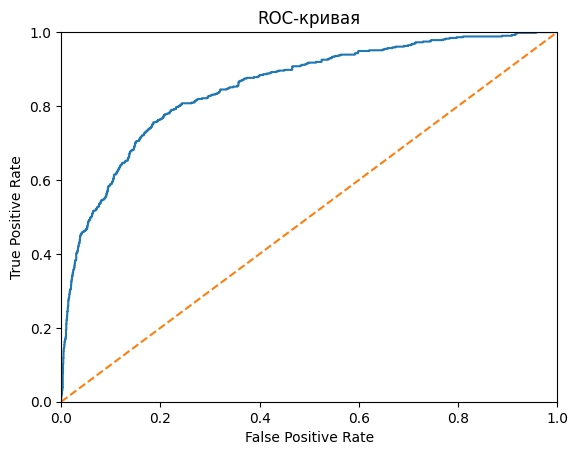

In [36]:
#построим ROC-кривую и проверим метрику AUC-ROC для model2 не тестовых данных
# - модель случайного леса с n_estimators = 29 и max_depth = 9, увеличение выборки

probabilities2_test = model2.predict_proba(features_test)
probabilities2_one_test = probabilities2_test[:, 1]

auc_roc = roc_auc_score(target_test, probabilities2_one_test)
print(f'Значение метрики AUC-ROC на тестовых данных для model2: {auc_roc:.6f}')

fpr, tpr, thresholds = roc_curve(target_test, probabilities2_one_test)
plt.figure()
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Выводы по п.4.2:
- модель случайного леса с n_estimators = 29 и max_depth = 12, увеличение выборки, показала f1_score на тестовых данных 0.598441, этого достаточно для удовлетворения условиям задачи
- Значение метрики AUC-ROC на тестовых данных для финальной модели: 0.852277


<div class="alert alert-block alert-info">
<b>Совет:</b> Вычисление/вывод метрик и графиков можно было бы как-то вынести в функцию и избежать дублирования кода и сделать его лаконичнее
</div>


<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b>
Согласен, что-то в этом есть. Явно одинаковые куски, буду стараться в будущем их выность в функции.
</div>

<b>Итого по п.4:</b>
- модель для проведения итогового тестирования обучена на подобранных в п.3 параметрах: n_estimators = 29 и max_depth = 12, взвешивание классов, f1_score 0.614925
- f1_score соответствует данным из п.3, можно приступать к финальному тестированию
- модель случайного леса с n_estimators = 29 и max_depth = 12, увеличение выборки, показала f1_score на тестовых данных 0.598441, этого достаточно для удовлетворения условиям задачи
- Значение метрики AUC-ROC на тестовых данных для финальной модели: 0.852277

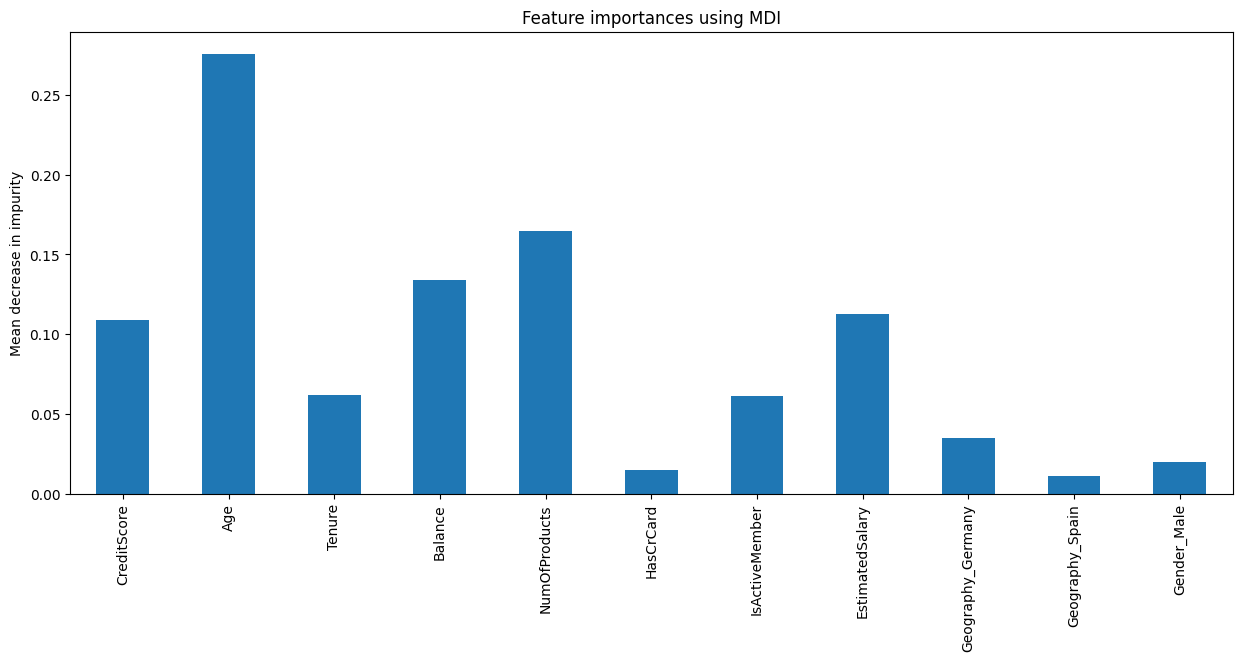

In [37]:
importances = model2.feature_importances_
forest_importances = pd.Series(importances, index=list(features_test))

plt.figure(figsize=(15, 6))
forest_importances.plot.bar();
plt.title("Feature importances using MDI")
plt.ylabel("Mean decrease in impurity")
plt.show()

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*

## Итоговые выводы по проекту

- Данные импортированы успешно, набор признаков в датасете совпадает с документацией.
- Значения null в признаке Tenure заменили на ноль, в рамках исследования мы будет трактовать клинтов с таким значением признака, как людей, являющихся клиентами банка менее года.
- Целевой признак Exited - категориальный (либо клиент ушел из банка, либо нет), значи перед нами в данном исследовании стоит задача классификации.
- Поскольку в рамках данного анализа мы будем использовать только модели линейной регрессии, решающего дерева и случайного леса, у нас нет необходимости производить масштабирование (среднее арифметическое = 0, дисперсия = 1), так как данные методы машиного обучения не чувствительны к различию в масштабах признаков.
- Отрицательных ответов почти в 4 раза больше, чем положительных - целевой признак нельзя назвать сбалансированным
- Без учета дисбаланса классов, исследованы и протестированы 3 модели для задачи классификации:
    - Модель решающего дерева
    - Модель случайного леса
    - Модель логистической регрессии
- Для данных с несбалансированными классами наиболее точной оказалась модель случайного леса, показавшая результат f1_score 0.55774 с количеством деревьев равным 19 и максимальной глубиной в 19
- Исследовали все модели при балансировании классов с помощью трех методов:
    - Метод взвешивания классов
    - Метод увеличения выборки
    - Метод уменьшения выборки
- В рамках исследования лучше всего показали себя модели, обученные на данных, сбалансированных путем взвешивания классов и увеличения выборки
- Метод уменьшения выборки показал более низкие результаты, в финальном тестировании его нет смысла использовать
- Порог валидности моделей для данной задачи составляет f1_score > 0.59, его преодолели 2 модели:
    - Модель случайного леса с n_estimators = 28 и max_depth = 10, обученная на данных, балансировка классов в которых производилась методом взвешивания классов
    - Модель случайного леса с n_estimators = 29 и max_depth = 9, обученная на данных, балансировка классов в которых производилась методом увеличения выборки
- Модель решающего дерева с max_depth = 7, обученная на данных, балансировка классов в которых производилась методом взвешивания классов, не перешал порог валидности в 0.59, но приблизилась к нему вплотную, проведем финальное тестирование на ней тоже, чтобы проверить, не перейдет ли ее результат за порог валидности для данной задачи.
- Результаты проверки моделей на тестовых данных:
    - model1 - модель случайного леса с n_estimators = 28 и max_depth = 10, взвешивание классов, f1_score на тестовых данных 0.60166
    - model2 - модель случайного леса с n_estimators = 29 и max_depth = 9, увеличение выборки, f1_score на тестовых данных 0.625448
    - model3 - модель решающего дерева с max_depth = 7, взвешивание классов, f1_score на тестовых данных 0.57873
- Наилучший результат показала model2 c f1_score на тестовых данных 0.625448
- model3 показала значение f1_score ниже порога в 0.59, далее мы ее  не рассматриваем
- Проверили значение метрики AUC-ROC для двух моделей - model1 и model2:
    - AUC-ROC на тестовых данных для model1: 0.855440
    - AUC-ROC на тестовых данных для model2: 0.861605
- model1 и model2 показали близкие результаты по метрике AUC-ROC и сходные графики ROC-кривых, при этом model2, показавшая более высокий f1_score - показала и более высокий AUC-ROC

## Проверка метрик на моделях бустинга

### Проверка метрик на модели CatBoost на несбалансированных признаках

In [38]:
X_train = features_train
X_valid = features_valid
y_train = target_train
y_valid = target_valid

In [39]:
params = {'loss_function':'Logloss',
          'eval_metric':'F1',
          'verbose': 100,
          'random_seed': 12345
         }

cbc = CatBoostClassifier(**params)

cbc.fit(X_train, y_train,
          eval_set=(X_valid, y_valid),
         use_best_model=True,
          plot=True
         );

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.047158
0:	learn: 0.5380711	test: 0.5000000	best: 0.5000000 (0)	total: 167ms	remaining: 2m 47s
100:	learn: 0.6292835	test: 0.5551331	best: 0.5551331 (96)	total: 488ms	remaining: 4.34s
200:	learn: 0.6758538	test: 0.5707257	best: 0.5749386 (187)	total: 811ms	remaining: 3.23s
300:	learn: 0.7144550	test: 0.5835351	best: 0.5863747 (244)	total: 1.15s	remaining: 2.67s
400:	learn: 0.7476526	test: 0.5848375	best: 0.5910736 (379)	total: 1.5s	remaining: 2.25s
500:	learn: 0.7860011	test: 0.5875300	best: 0.5916168 (497)	total: 1.83s	remaining: 1.82s
600:	learn: 0.8124646	test: 0.5844311	best: 0.5916168 (497)	total: 2.16s	remaining: 1.44s
700:	learn: 0.8346369	test: 0.5887962	best: 0.5916168 (497)	total: 2.58s	remaining: 1.1s
800:	learn: 0.8582460	test: 0.5857143	best: 0.5916168 (497)	total: 3.11s	remaining: 772ms
900:	learn: 0.8771739	test: 0.5808737	best: 0.5916168 (497)	total: 3.63s	remaining: 399ms
999:	learn: 0.8927224	test: 0.5865724	best: 0.5916168 (497)	total: 4.21s	rem

### Проверка метрик на модели CatBoost на увеличинной выборке

In [42]:
X_train = features_upsampled
X_valid = features_valid
y_train = target_upsampled
y_valid = target_valid

In [43]:
params = {'loss_function':'Logloss',
          'eval_metric':'F1',
          'verbose': 100,
          'random_seed': 12345
         }

cbc = CatBoostClassifier(**params)

cbc.fit(X_train, y_train,
          eval_set=(X_valid, y_valid),
         use_best_model=True,
          plot=True
         );

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.053056
0:	learn: 0.7597711	test: 0.5360972	best: 0.5360972 (0)	total: 4.76ms	remaining: 4.75s
100:	learn: 0.8224112	test: 0.5998357	best: 0.6101142 (73)	total: 421ms	remaining: 3.75s
200:	learn: 0.8620562	test: 0.6127946	best: 0.6144781 (189)	total: 796ms	remaining: 3.16s
300:	learn: 0.8997795	test: 0.6152513	best: 0.6168549 (299)	total: 1.2s	remaining: 2.79s
400:	learn: 0.9251701	test: 0.6163410	best: 0.6203866 (347)	total: 1.59s	remaining: 2.38s
500:	learn: 0.9403748	test: 0.6182796	best: 0.6211849 (476)	total: 1.98s	remaining: 1.97s
600:	learn: 0.9559199	test: 0.6179159	best: 0.6217430 (503)	total: 2.36s	remaining: 1.57s
700:	learn: 0.9641250	test: 0.6136784	best: 0.6217430 (503)	total: 2.74s	remaining: 1.17s
800:	learn: 0.9763206	test: 0.6169618	best: 0.6217430 (503)	total: 3.25s	remaining: 808ms
900:	learn: 0.9852121	test: 0.6210131	best: 0.6248831 (852)	total: 3.64s	remaining: 400ms
999:	learn: 0.9891898	test: 0.6089439	best: 0.6248831 (852)	total: 4.03s	re